<style>
    .jp-Notebook, .container {
        max-width: 950px !important;
        margin: 0 auto !important;
        background-color: white;
    }
    #notebook-container {
        box-shadow: 0 0 10px rgba(0,0,0,0.1);
        padding: 2em;
    }
   .jp-CodeMirror, .CodeMirror, .jp-Editor, .jp-InputArea-editor {
    overflow-x: auto !important;
    }

    .jp-CodeMirror pre, .CodeMirror pre {
    white-space: pre !important;
    word-wrap: normal !important;
    }
    div.input_area {
    overflow-x: auto !important;
    }
    div.input_area pre {
    white-space: pre !important;
    width: max-content !important;
    }
    table {
        margin-left: auto !important;
        margin-right: auto !important;
    }
</style>

# Gapminder Data Analysis Report

## Table of Contents
* [1. Technical Framework](#Technical-Framework)
    * [1.1 Core pachages](#Core-packages)
    * [1.2 Dataset acquisition](#Dataset-acquisition)
* [2. Global wealth vs. carbon footprint](#Global-wealth-vs.-carbon-footprint)
    * [3.1 Snapshot of 1962: The economic-environmental link](#Snapshot-of-1962:-The-economic-environmental-link)
    * [3.2 Quantifying the correlation](#Quantifying-the-correlation)
* [3. Exploratory data analysis (EDA)](#Exploratory-data-analysis)
    * [3.1 Continental disparities in energy consumption](#Continental-disparities-in-energy-consumption)
    * [3.2 Comparative analysis of import reliance: Europe vs. Asia](#Comparative-analysis-of-import-reliance:-Europe-vs.-Asia)
* [4. Global demographic benchmarks](#Global-demographic-benchmarks)
    * [4.1 Population density Champions](#Population-Density-Champions)
    * [4.2 Half a century of progress: life expectancy gains](#Half-a-century-of-progress:-life-expectancy-gains)

<a id=Technical-Framework></a>
# Technical Framework

<a id=Core-packages></a>
## Core packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from IPython.display import Markdown
from scipy import stats
from scipy.stats import shapiro, mannwhitneyu, ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
plt.style.use("seaborn-v0_8")
plt.rcParams['figure.figsize'] = [10, 6] 
sns.set_theme(style="whitegrid")
pio.templates.default = "plotly_white"
pio.renderers.default = "notebook_connected"

<a id=Dataset-acquisition></a>
## Dataset acquisition

Reading the file reveals that the dataset describes the following variables:

In [3]:
df = pd.read_csv("gapminder_clean.csv").drop(columns=["Unnamed: 0"])

df_display = pd.DataFrame({"Data presented": df.columns})
Markdown(df_display.to_markdown(index=False))

| Data presented                                          |
|:--------------------------------------------------------|
| Country Name                                            |
| Year                                                    |
| Agriculture, value added (% of GDP)                     |
| CO2 emissions (metric tons per capita)                  |
| Domestic credit provided by financial sector (% of GDP) |
| Electric power consumption (kWh per capita)             |
| Energy use (kg of oil equivalent per capita)            |
| Exports of goods and services (% of GDP)                |
| Fertility rate, total (births per woman)                |
| GDP growth (annual %)                                   |
| Imports of goods and services (% of GDP)                |
| Industry, value added (% of GDP)                        |
| Inflation, GDP deflator (annual %)                      |
| Life expectancy at birth, total (years)                 |
| Population density (people per sq. km of land area)     |
| Services, etc., value added (% of GDP)                  |
| pop                                                     |
| continent                                               |
| gdpPercap                                               |

<a id=Global-wealth-vs.-carbon-footprint></a>
# Global wealth vs. carbon footprint

<a id=Snapshot-of-1962:-The-economic-environmental-link></a>
## Snapshot of 1962: The economic-environmental link

Data for 1962 is shown on a log‑scaled axis to make densely clustered countries easier to distinguish, while the tick labels remain in the original units so the values stay intuitive to read.

In [4]:
df_1962 = df[df["Year"] == 1962]
fig = px.scatter(
    df_1962,
    x="gdpPercap",
    y="CO2 emissions (metric tons per capita)",
    log_x=True,
    log_y=True,
    hover_data=["Country Name"],
    title="Global correlation between GDP and CO<sub>2</sub> emissions (1962) <br>Logarithmic Scale",
    labels={
        "CO2 emissions (metric tons per capita)": "CO<sub>2</sub> emissions (t/capita)",
        "gdpPercap": "GDP per Capita",
    },
)
fig.update_xaxes(
    type="log", range=[2, None], tickmode="auto", nticks=10, tickformat="$,~s"
)
y_ticks = [0.01, 0.1, 1, 10, 50]
fig.update_yaxes(
    type="log", tickmode="array", tickvals=y_ticks, ticktext=[str(v) for v in y_ticks]
)
fig.update_traces(
    hovertemplate=(
        "<b>%{customdata[0]}</b><br>"  # Country
        "GDP per Capita: %{x:$,.0f}<br>"
        "CO₂ emissions: %{y:.3g} t/capita<br>"
        "<extra></extra>"
    ),
    customdata=df_1962[["Country Name"]],
)
fig.show()

A specific data point represents a suspicious outlier, warranting further inspection of the underlying data.

A review of the literature reveals the following findings. The spike in Kuwait’s CO₂ emissions in 1962—which reached world-record levels on a per capita basis—was primarily driven by the massive flaring of associated petroleum gas. During this period, the country rapidly expanded oil production following its independence (1961), but lacked the infrastructure to capture or utilize the natural gas released during extraction, resulting in it being burned off as waste. Because these vast industrial emissions were divided by a relatively small population (358,266 people at the time - according to this data set), the mathematical result was an extreme statistical anomaly that far exceeded the per capita output of even the most industrialized Western nations.

<a id=Quantifying-the-correlation></a>
## Quantifying the correlation

To quantify the strength and direction of the linear relationship between GDP per capita and CO₂ emissions, a Pearson correlation test was conducted.

In [5]:
df_clean = df_1962[["CO2 emissions (metric tons per capita)", "gdpPercap"]].dropna()
r, p_value = stats.pearsonr(
    df_clean["CO2 emissions (metric tons per capita)"], df_clean["gdpPercap"]
)

Markdown(
    f"""
The strong positive correlation between GDP per capita and CO₂ emissions (**r = {r:.4f}**, **p = {p_value:.2e}**) shows that wealthier countries tended to emit more carbon that year.  
The next step is to scan all years and find the moment when this relationship between wealth and emissions was at its strongest.
"""
)


The strong positive correlation between GDP per capita and CO₂ emissions (**r = 0.9261**, **p = 1.13e-46**) shows that wealthier countries tended to emit more carbon that year.  
The next step is to scan all years and find the moment when this relationship between wealth and emissions was at its strongest.


In [6]:
yearly_corr = (
    df.groupby("Year")[["CO2 emissions (metric tons per capita)", "gdpPercap"]]
    .corr()
    .unstack()["CO2 emissions (metric tons per capita)"]["gdpPercap"]
)
best_year = yearly_corr.idxmax()

Markdown(
    f"""
The follow‑up correlation analysis across all years shows that the strongest link between GDP per capita and CO₂ emissions emerged in {best_year}.
"""
)


The follow‑up correlation analysis across all years shows that the strongest link between GDP per capita and CO₂ emissions emerged in 1967.


Now let’s focus and discover this period of time 

In [7]:
df_best_year = df[df["Year"] == best_year]
fig = px.scatter(
    df_best_year,
    x="gdpPercap",
    y="CO2 emissions (metric tons per capita)",
    size="pop",
    size_max=40,
    color="continent",
    log_x=True,
    log_y=True,
    hover_data=["Country Name", "Year"],
    title="CO<sub>2</sub> emissions vs GDP per capita <br>Logarithmic Scale",
    labels={
        "CO2 emissions (metric tons per capita)": "CO<sub>2</sub> emissions (t/capita)",
        "gdpPercap": "GDP per capita",
    },
)
fig.update_traces(
    marker=dict(sizemode="area", sizemin=5),
    hovertemplate=(
        "<b>%{customdata[0]}</b><br>"
        "GDP per Capita: %{x:$,.0f}<br>"
        "CO₂ emissions: %{y:.3g} t/capita<br>"
        "<extra></extra>"
    ),
    customdata=df_1962[["Country Name"]],
)
fig.update_xaxes(
    type="log", range=[2, None], tickmode="auto", nticks=5, tickformat="~s"
)
y_ticks = [0.01, 0.1, 1, 10, 50]
fig.update_yaxes(
    type="log", tickmode="array", tickvals=y_ticks, ticktext=[str(v) for v in y_ticks]
)
fig.update_layout(legend_title_text="Continents")
fig.show()

Note that the size of each circle reflects the country’s population, though the size legend has been omitted for clarity.

<a id=Exploratory-data-analysis></a>
# Exploratory data analysis (EDA)

<a id=Continental-disparities-in-energy-consumption></a>
## Continental disparities in energy consumption

Question 1. What is the relationship between `continent` and `'Energy use (kg of oil equivalent per capita)'`?

Since the independent variable (continent) is categorical and the dependent variable (energy use) is quantitative, the initial analysis focused on comparing mean energy consumption across continents. Although the primary goal was to evaluate the effect of continent alone, the dataset spans multiple years, raising the possibility that temporal variation could bias the group differences. To address this concern, a deeper analysis was conducted: a two‑way ANOVA was used to test whether year or the continent‑by‑year interaction could distort the results, followed by simple‑effects tests within each year. This confirmed that the differences between continents are present both in the overall trend and consistently across all individual years.

In [8]:
df_clean = df.dropna(
    subset=["Energy use (kg of oil equivalent per capita)", "continent", "Year"]
)
model = ols(
    'Q("Energy use (kg of oil equivalent per capita)") ~ C(continent) * C(Year)',
    data=df_clean,
).fit()
anova_table = sm.stats.anova_lm(model, typ=2).reset_index()
anova_table.rename(columns={"index": "Factor"}, inplace=True)
anova_table["Conclusion"] = anova_table["PR(>F)"].apply(
    lambda p: "Reject H₀ — effect exists"
    if p < 0.05
    else "Fail to reject H₀ — no effect"
)

Markdown(
    "## Two-way ANOVA results (continent × year)\n\n"
    + anova_table.to_markdown(index=False)
)

## Two-way ANOVA results (continent × year)

| Factor               |      sum_sq |   df |         F |        PR(>F) | Conclusion                    |
|:---------------------|------------:|-----:|----------:|--------------:|:------------------------------|
| C(continent)         | 7.16055e+08 |    4 |  48.4648  |   1.59885e-36 | Reject H₀ — effect exists     |
| C(Year)              | 2.45868e+08 |    9 |   7.39605 |   2.04793e-10 | Reject H₀ — effect exists     |
| C(continent):C(Year) | 2.31637e+08 |   36 |   1.74199 |   0.00492409  | Reject H₀ — effect exists     |
| Residual             | 2.95495e+09 |  800 | nan       | nan           | Fail to reject H₀ — no effect |

In [9]:
rows = []
for year in sorted(df_clean["Year"].unique()):
    subset = df_clean[df_clean["Year"] == year]
    groups = [
        g["Energy use (kg of oil equivalent per capita)"].values
        for _, g in subset.groupby("continent")
    ]
    if len(groups) < 2:
        continue
    f, p = stats.f_oneway(*groups)
    conclusion = (
        "Fail to reject H₀ — no difference"
        if p > 0.05
        else "Reject H₀ — difference exists"
    )
    rows.append([year, round(f, 3), round(p, 6), conclusion])
simple_effects = pd.DataFrame(
    rows, columns=["Year", "F‑statistic", "p‑value", "Conclusion"]
)

Markdown(
    "## Simple effects: ANOVA within each year\n\n"
    + simple_effects.to_markdown(index=False)
)

## Simple effects: ANOVA within each year

|   Year |   F‑statistic |   p‑value | Conclusion                    |
|-------:|--------------:|----------:|:------------------------------|
|   1962 |         8.738 |  0.000664 | Reject H₀ — difference exists |
|   1967 |         9.642 |  0.000334 | Reject H₀ — difference exists |
|   1972 |         7.367 |  3.6e-05  | Reject H₀ — difference exists |
|   1977 |         8.456 |  8e-06    | Reject H₀ — difference exists |
|   1982 |         7.552 |  2.7e-05  | Reject H₀ — difference exists |
|   1987 |         8.496 |  7e-06    | Reject H₀ — difference exists |
|   1992 |         7.898 |  1.5e-05  | Reject H₀ — difference exists |
|   1997 |         7.057 |  4.9e-05  | Reject H₀ — difference exists |
|   2002 |         6.637 |  9e-05    | Reject H₀ — difference exists |
|   2007 |         6.328 |  0.000131 | Reject H₀ — difference exists |

For assessing overall differences between specific continents, the Tukey post‑hoc test was applied to all available observations. Since the two‑way ANOVA revealed a significant interaction between year and continent, an additional simple‑effects analysis (year‑specific ANOVA) was conducted. All years showed consistent differences between continents, confirming that the global Tukey results are not distorted by the temporal structure of the data and reflect genuine aggregate differences between continents.

In [10]:
df_clean = df.dropna(
    subset=["Energy use (kg of oil equivalent per capita)", "continent"]
)
tukey = pairwise_tukeyhsd(
    endog=df_clean["Energy use (kg of oil equivalent per capita)"],
    groups=df_clean["continent"],
    alpha=0.05,
)

raw = tukey.summary()
tukey_df = pd.DataFrame(raw.data[1:], columns=raw.data[0])
merged = tukey_df.iloc[:, 0] + " vs " + tukey_df.iloc[:, 1]
tukey_df.insert(0, "comparison", merged)
tukey_df = tukey_df.drop(columns=tukey_df.columns[1:3])
tukey_df = tukey_df.reset_index(drop=True)

Markdown(tukey_df.to_markdown(index=False))

| comparison          |   meandiff |   p-adj |    lower |    upper | reject   |
|:--------------------|-----------:|--------:|---------:|---------:|:---------|
| Africa vs Americas  |   1005.1   |  0      |  466.833 | 1543.37  | True     |
| Africa vs Asia      |   1168.76  |  0      |  628.253 | 1709.27  | True     |
| Africa vs Europe    |   2447.55  |  0      | 1947.38  | 2947.71  | True     |
| Africa vs Oceania   |   3281.8   |  0      | 2040.34  | 4523.25  | True     |
| Americas vs Asia    |    163.66  |  0.9256 | -384.416 |  711.736 | False    |
| Americas vs Europe  |   1442.44  |  0      |  934.114 | 1950.77  | True     |
| Americas vs Oceania |   2276.69  |  0      | 1031.92  | 3521.46  | True     |
| Asia vs Europe      |   1278.78  |  0      |  768.083 | 1789.48  | True     |
| Asia vs Oceania     |   2113.03  |  0      |  867.295 | 3358.77  | True     |
| Europe vs Oceania   |    834.252 |  0.3422 | -394.518 | 2063.02  | False    |

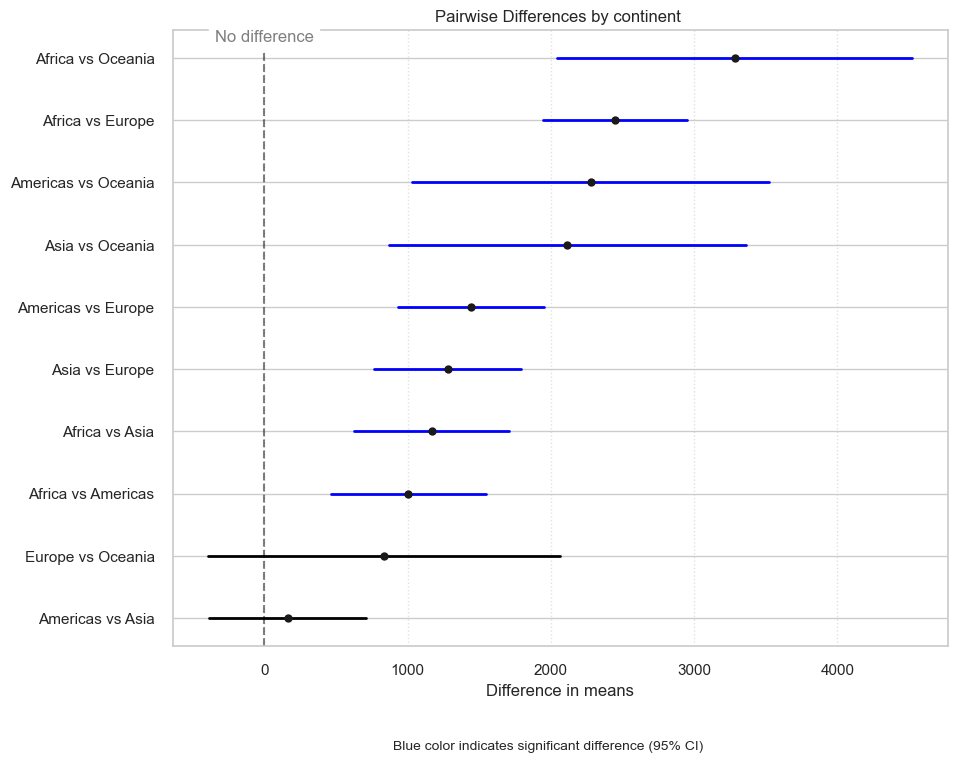

In [11]:
tukey_df = (
    pd.DataFrame(tukey.summary().data[1:], columns=tukey.summary().data[0])
    .sort_values(by="meandiff")
    .reset_index(drop=True)
)
plt.figure(figsize=(10, 8))

for i, row in tukey_df.iterrows():
    color = "blue" if row["reject"] else "black"
    plt.plot([row["lower"], row["upper"]], [i, i], color=color, linewidth=2)
    plt.plot(row["meandiff"], i, "ko")
plt.axvline(x=0, color="black", linestyle="--", alpha=0.5)
plt.text(
    0.0,
    plt.ylim()[1],
    "No difference",
    ha="center",
    va="top",
    fontsize=12,
    color="grey",
    backgroundcolor="white",
)
pairs = tukey_df["group1"] + " vs " + tukey_df["group2"]
plt.yticks(range(len(tukey_df)), pairs)
plt.xlabel("Difference in means")
plt.title("Pairwise Differences by continent ")
plt.figtext(
    0.5,
    -0.02,
    "Blue color indicates significant difference (95% CI)",
    ha="center",
    fontsize=10,
)
plt.grid(axis="x", linestyle=":", alpha=0.6)
plt.show()

The ANOVA results demonstrate that continent is a decisive factor shaping energy consumption levels, both in the overall dataset and consistently across all individual years. A follow‑up Tukey test showed that almost all continent pairs differ significantly, with the exceptions of the Oceania–Europe and Asia–Americas pairs, whose energy consumption levels remain statistically similar in the aggregate trend and within each examined year.

<a id=Comparative-analysis-of-import-reliance:-Europe-vs.-Asia></a>
## Comparative analysis of import reliance: Europe vs. Asia

Question 2. Is there a significant difference between Europe and Asia with respect to `'Imports of goods and services (% of GDP)'` in the years after 1990?

This is a classic statistical problem: comparing two groups to determine whether a significant difference exists between them. Our grouping (independent) variable is categorical with exactly two levels. The dependent variable is continuous (interval/ratio).

Following the standard statistical flowchart, the Independent Samples T-test was selected. A key prerequisite for this test is that the data within both groups must follow a normal distribution. To verify this assumption, the Shapiro-Wilk test can be employed. If the p-value is less than 0.05, the null hypothesis of normality is rejected, indicating that the distribution cannot be considered normal. Because the dataset spans multiple years, combining all observations into a single distribution could introduce bias. Some countries act as persistent “high‑consumption leaders,” and if their values are aggregated across all years, they may disproportionately shift the overall median and artificially inflate or suppress the apparent difference between continents. To avoid this distortion, the normality assumption was evaluated separately for each year using the Shapiro–Wilk test.

In [12]:
df_filtered = df[(df["Year"] > 1990) & df["continent"].isin(["Asia", "Europe"])]
results = []
for year, df_year in df_filtered.groupby("Year"):
    asia = df_year[df_year["continent"] == "Asia"][
        "Imports of goods and services (% of GDP)"
    ].dropna()
    europe = df_year[df_year["continent"] == "Europe"][
        "Imports of goods and services (% of GDP)"
    ].dropna()

    if len(asia) < 3 or len(europe) < 3:
        continue

    p_asia = shapiro(asia)[1]
    p_europe = shapiro(europe)[1]

    normal = (p_asia > 0.05) and (p_europe > 0.05)

    if normal:
        stat, p = ttest_ind(asia, europe, equal_var=False)
        test = "t-test"
    else:
        stat, p = mannwhitneyu(asia, europe, alternative="two-sided")
        test = "Mann–Whitney"

    results.append(
        {"Year": year, "p-value": p, "Asia stats": p_asia, "Europe stats": p_europe}
    )

results_df = pd.DataFrame(results).rename(
    columns={
        "p-value": "p-value",
        "Asia stats": "Asia stats",
        "Europe stats": "Europe stats",
    }
)

Markdown(results_df.to_markdown(index=False))

|   Year |   p-value |   Asia stats |   Europe stats |
|-------:|----------:|-------------:|---------------:|
|   1992 |  0.488371 |  0.0072914   |      0.0014222 |
|   1997 |  0.330138 |  0.00130564  |      0.0144044 |
|   2002 |  0.901936 |  0.000831277 |      0.0310031 |
|   2007 |  0.397506 |  0.000555961 |      0.0664254 |

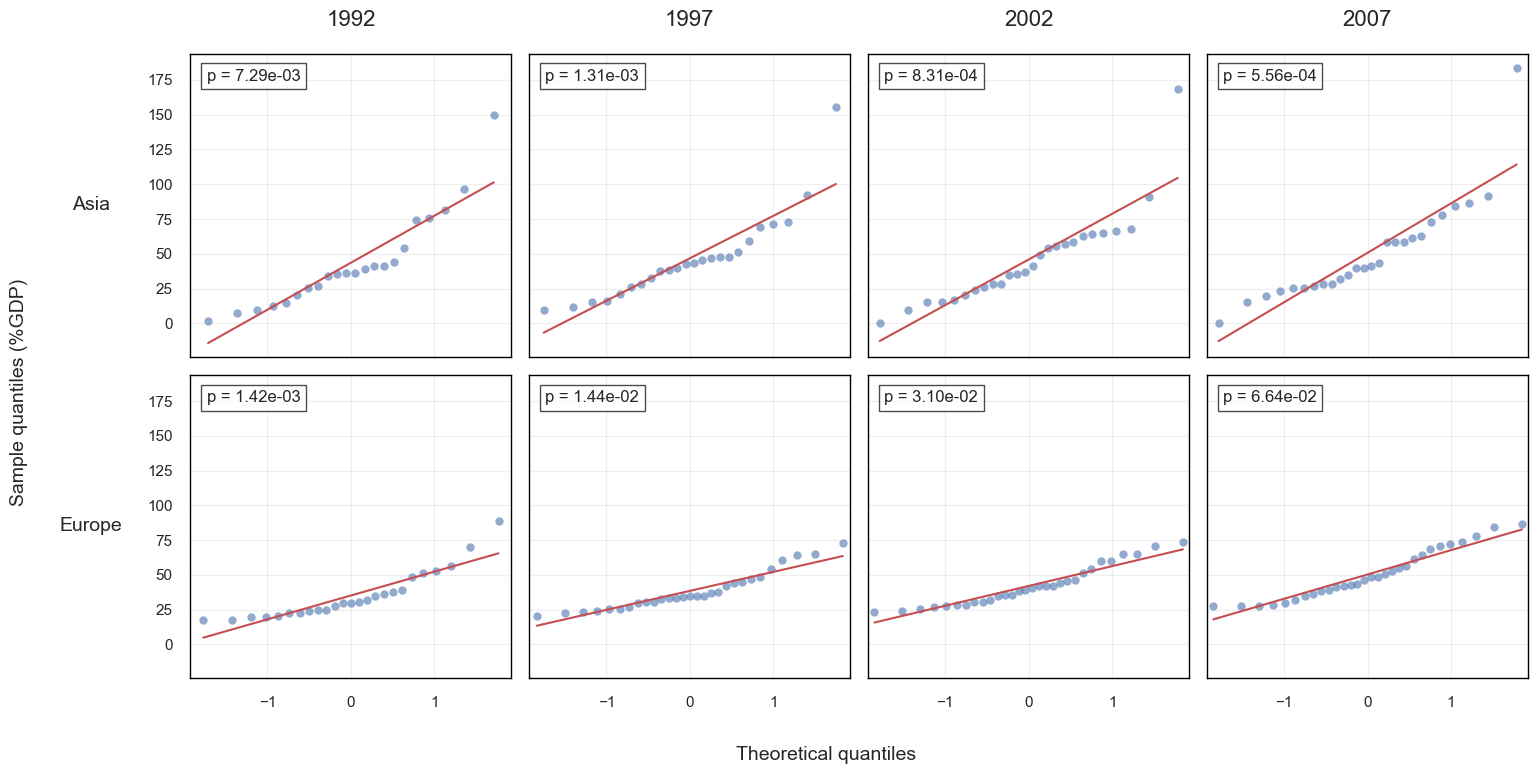

In [13]:
years = sorted(df_filtered["Year"].unique())
continents = ["Asia", "Europe"]
rows = len(continents)
cols = len(years)
fig, axes = plt.subplots(
    rows, cols, figsize=(cols * 4, rows * 4), sharex=True, sharey=True
)
if rows == 1:
    axes = axes.reshape(1, -1)
if cols == 1:
    axes = axes.reshape(-1, 1)
for i, cont in enumerate(continents):
    for j, year in enumerate(years):
        ax = axes[i, j]
        df_year = df_filtered[df_filtered["Year"] == year]
        data = df_year[df_year["continent"] == cont][
            "Imports of goods and services (% of GDP)"
        ].dropna()
        sm.qqplot(data, line="s", ax=ax, alpha=0.6)
        ax.set_xlabel("")
        p_val = shapiro(data)[1]
        ax.grid(alpha=0.3)
        ax.text(
            0.05,
            0.95,
            f"p = {p_val:.2e}",
            transform=ax.transAxes,
            ha="left",
            va="top",
            fontsize=12,
            bbox=dict(facecolor="white", edgecolor="black", alpha=0.7),
        )
        if j == 0:
            ax.set_ylabel(cont, fontsize=14, rotation=0, labelpad=40, va="center")
        else:
            ax.set_ylabel("")
        if i == 0:
            ax.set_title(str(year), fontsize=16, pad=20)
        if i < rows - 1:
            ax.tick_params(labelbottom=False)
        if j > 0:
            ax.tick_params(labelleft=False)
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(1)
            spine.set_color("black")
fig.text(
    0.04, 0.5, "Sample quantiles (%GDP)", va="center", rotation="vertical", fontsize=14
)
fig.text(0.55, 0.04, "Theoretical quantiles", ha="center", fontsize=14)
plt.tight_layout(rect=[0.06, 0.08, 1, 1])
plt.show()

 In every year, at least one of the two groups deviated significantly from normality (p < 0.05), indicating that the distributions were consistently non‑normal. Given this year‑by‑year violation and the need to prevent repeated extreme values from dominating the pooled distribution, the Mann–Whitney U test was applied within each year, ensuring that each country contributes only once per time point and that the comparison between continents is not biased by temporal accumulation of extreme observations.


In [14]:
results = []
for year in sorted(df_filtered["Year"].unique()):
    df_year = df_filtered[df_filtered["Year"] == year]
    asia = df_year[df_year["continent"] == "Asia"][
        "Imports of goods and services (% of GDP)"
    ].dropna()
    europe = df_year[df_year["continent"] == "Europe"][
        "Imports of goods and services (% of GDP)"
    ].dropna()
    if len(asia) > 0 and len(europe) > 0:
        stat, p = stats.mannwhitneyu(asia, europe, alternative="two-sided")
        results.append((year, stat, p))
table = pd.DataFrame(results, columns=["Year", "U‑statistic", "p‑value"])
table["U‑statistic"] = table["U‑statistic"].round(1)
table["p‑value"] = table["p‑value"].round(4)
table["Conclusion"] = table["p‑value"].apply(
    lambda p: "Fail to reject H₀ — no difference"
    if p > 0.05
    else "Reject H₀ — difference exists"
)
md_table = table.to_markdown(index=False)

display(Markdown("## Mann–Whitney U test results by year (after 1990)\n\n" + md_table))

## Mann–Whitney U test results by year (after 1990)

|   Year |   U‑statistic |   p‑value | Conclusion                        |
|-------:|--------------:|----------:|:----------------------------------|
|   1992 |           308 |    0.4884 | Fail to reject H₀ — no difference |
|   1997 |           403 |    0.3301 | Fail to reject H₀ — no difference |
|   2002 |           382 |    0.9019 | Fail to reject H₀ — no difference |
|   2007 |           338 |    0.3975 | Fail to reject H₀ — no difference |

In [15]:
plot_df = df_filtered[
    ["continent", "Year", "Imports of goods and services (% of GDP)", "Country Name"]
].copy()
fig = px.box(
    plot_df,
    x="continent",
    y="Imports of goods and services (% of GDP)",
    points="outliers",
    facet_col="Year",
    category_orders={"continent": ["Asia", "Europe"]},
    title="Import comparison: Asia vs. Europe (% of GDP) by Year",
    custom_data=["Country Name"],
)
fig.update_traces(
    marker=dict(size=6, opacity=0.8),
    hovertemplate=("<b>%{customdata[0]}</b><br>" "Imports: %{y:.0f}" "<extra></extra>"),
)
fig.update_layout(showlegend=False)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_xaxes(title_text="")
fig.add_annotation(
    x=0.5,
    y=-0.1,
    xref="paper",
    yref="paper",
    text="Continent",
    showarrow=False,
    yshift=-30,
    font=dict(size=16),
)
fig.show()

The boxplots show that Asia’s distribution is distorted almost entirely by a single country that appears as an extreme outlier in every year. This single observation could substantially shift the arithmetic mean, but it has no influence on the median. Once the outlier’s effect is isolated, the underlying distributions of Asia and Europe appear remarkably similar, and the comparison of medians confirms that there is no meaningful difference between the two regions.

<a id=Global-demographic-benchmarks></a>
# Global Demographic Benchmarks

<a id=Population-Density-Champions></a>
## Population Density Champions

Question 3. What is the country (or countries) that has the highest `'Population density (people per sq. km of land area)'` across all years? (i.e., which country has the highest average ranking in this category across each time point in the dataset?)

In [16]:
df["Rank"] = df.groupby("Year")[
    "Population density (people per sq. km of land area)"
].rank(ascending=False)
df_sorted = df.sort_values(by=["Year", "Rank"])
average_ranks = df.groupby("Country Name")["Rank"].mean()
top_stable_countries = average_ranks.sort_values().head(10)

table = top_stable_countries.reset_index()
table.columns = ["Country", "Average Rank"]

Markdown(
    "## Top 10 countries with high population density\n\n"
    + table.to_markdown(index=False)
)

## Top 10 countries with high population density

| Country                   |   Average Rank |
|:--------------------------|---------------:|
| Monaco                    |            1.5 |
| Macao SAR, China          |            1.5 |
| Hong Kong SAR, China      |            3.1 |
| Singapore                 |            3.9 |
| Gibraltar                 |            5   |
| Bermuda                   |            6.2 |
| Malta                     |            7   |
| Bangladesh                |            9.2 |
| Channel Islands           |            9.4 |
| Sint Maarten (Dutch part) |           10.5 |

Macao SAR, China and Monaco are the top-ranked territories, maintaining a peak average rank of 1.5 over the 10-year period. To evaluate leadership stability rather than a single-year snapshot, annual ranking was used instead of mean values. Continent-based filtering was intentionally avoided, as these territories frequently have missing (NA) values in the continent field. Including these official statistical units ensures accuracy, as their exclusion would have incorrectly identified Singapore as the leader, failing the criteria for the highest density in the data set.

<a id=Half-a-century-of-progress:-life-expectancy-gains></a>
## Half a century of progress: life expectancy gains

Question 4. What country (or countries) has shown the greatest increase in `'Life expectancy at birth, total (years)'` between 1962 and 2007? 

In [17]:
df_62_07 = df[(df["Year"] >= 1962) & (df["Year"] <= 2007)].copy()
years = (
    df_62_07.groupby("Country Name")["Year"]
    .agg(min_year="min", max_year="max")
    .reset_index()
)
life_min = (
    df_62_07.merge(
        years[["Country Name", "min_year"]],
        left_on=["Country Name", "Year"],
        right_on=["Country Name", "min_year"],
        how="inner",
    )[["Country Name", "min_year", "Life expectancy at birth, total (years)"]]
    .drop_duplicates()
    .rename(columns={"Life expectancy at birth, total (years)": "life_min"})
)
life_max = (
    df_62_07.merge(
        years[["Country Name", "max_year"]],
        left_on=["Country Name", "Year"],
        right_on=["Country Name", "max_year"],
        how="inner",
    )[["Country Name", "max_year", "Life expectancy at birth, total (years)"]]
    .drop_duplicates()
    .rename(columns={"Life expectancy at birth, total (years)": "life_max"})
)
result = years.merge(life_min, on=["Country Name", "min_year"], how="left").merge(
    life_max, on=["Country Name", "max_year"], how="left"
)
result["duration"] = result["max_year"] - result["min_year"]
result["life_gain"] = result["life_max"] - result["life_min"]
result["rate"] = result["life_gain"] / result["duration"]
result = result.sort_values("life_gain", ascending=False).reset_index(drop=True)
table = result.head(10).copy()
table = table.rename(
    columns={
        "Country Name": "Country",
        "min_year": "Start Year",
        "max_year": "End Year",
        "life_min": "Life Expectancy (Start), years",
        "life_max": "Life Expectancy (End), years",
        "life_gain": "Total Gain (years)",
        "duration": "Years to count",
        "rate": "Annual Gain (years)",
    }
)

Markdown(
    "## Top 10 countries by life expectancy gain (1962–2007)\n\n"
    + table.to_markdown(index=False)
)

## Top 10 countries by life expectancy gain (1962–2007)

| Country            |   Start Year |   End Year |   Life Expectancy (Start), years |   Life Expectancy (End), years |   Years to count |   Total Gain (years) |   Annual Gain (years) |
|:-------------------|-------------:|-----------:|---------------------------------:|-------------------------------:|-----------------:|---------------------:|----------------------:|
| Maldives           |         1962 |       2007 |                          38.4836 |                        75.3997 |               45 |              36.9161 |              0.820359 |
| Bhutan             |         1962 |       2007 |                          33.0941 |                        66.2931 |               45 |              33.199  |              0.737754 |
| Timor-Leste        |         1962 |       2007 |                          34.739  |                        65.8242 |               45 |              31.0851 |              0.690781 |
| Tunisia            |         1962 |       2007 |                          43.3417 |                        74.2024 |               45 |              30.8608 |              0.685795 |
| Oman               |         1962 |       2007 |                          44.3005 |                        75.1236 |               45 |              30.8231 |              0.684958 |
| Nepal              |         1962 |       2007 |                          35.9523 |                        66.5519 |               45 |              30.5996 |              0.679992 |
| China              |         1962 |       2007 |                          44.3983 |                        74.3404 |               45 |              29.9421 |              0.66538  |
| Yemen, Rep.        |         1962 |       2007 |                          34.7396 |                        61.9548 |               45 |              27.2152 |              0.604783 |
| Saudi Arabia       |         1962 |       2007 |                          46.6945 |                        73.3451 |               45 |              26.6506 |              0.592235 |
| Iran, Islamic Rep. |         1962 |       2007 |                          46.0658 |                        72.6742 |               45 |              26.6084 |              0.591298 |

The Maldives experienced the highest increase in life expectancy between 1962 and 2007. During this period, the figure rose by 36.9 years (from 38.5 to 75.4 years), representing an average annual growth rate of 0.82 years. Other countries demonstrating significant progress include Bhutan (+33.2 years) and Timor-Leste (+31.1 years).